https://towardsdatascience.com/neural-networks-from-scratch-easy-vs-hard-b26ddc2e89c7

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import numpy as np

%matplotlib inline

(1797, 64)


<Figure size 432x288 with 0 Axes>

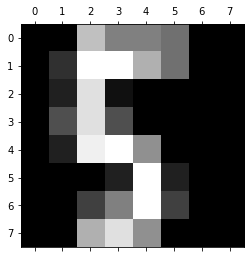

In [15]:
dig = load_digits()
plt.gray()
plt.matshow(dig.images[25])

onehot_target = pd.get_dummies(dig.target)



x_train, x_val, y_train, y_val = train_test_split(dig.data, onehot_target, test_size=0.1, random_state=20)
# shape of x_train :(1617, 64)
# shape of y_train :(1617, 10)
print(dig.data.shape)

Input layer - 64 neurons (input image array)
Hidden layer 1 - 128 neurons (arbitrary)
Hidden layer 2 - 128 neurons (arbitrary)
Output layer - 10 neurons (output one-hot array)

In [18]:
#with libraries
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import RMSprop, Adadelta, Adam
model = Sequential()
model.add(Dense(128, input_dim=x_train.shape[1], activation='sigmoid'))
model.add(Dense(128, activation='sigmoid'))
model.add(Dense(10, activation='softmax'))

model.summary()

model.compile(optimizer=Adadelta(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.fit(x_train, y_train, epochs=50, batch_size=64)

scores = model.evaluate(x_val, y_val)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))


Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total params: 26,122
Trainable params: 26,122
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
1617/1617 [==============================] - 0s 153us/step - loss: 2.0566 - categorical_accuracy: 0.4712
Epoch 2/50
1617/1617 [==============================] - 0s 27us/step - loss: 1.3693 - categorical_accuracy: 0.8411
Epoch 3/50
1617/1617 [==============================] - 0s 24us/step - loss: 0.8917 - categorical_accuracy: 0.9017
Epoch 4/50
1617/1617 [============

WITHOUT LIBRARIES

In [19]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

dig = load_digits()
onehot_target = pd.get_dummies(dig.target)
x_train, x_val, y_train, y_val = train_test_split(dig.data, onehot_target, test_size=0.1, random_state=20)

def sigmoid(s):
    return 1/(1 + np.exp(-s))

def sigmoid_derv(s):
    return s * (1 - s)

def softmax(s):
    exps = np.exp(s - np.max(s, axis=1, keepdims=True))
    return exps/np.sum(exps, axis=1, keepdims=True)

def cross_entropy(pred, real):
    n_samples = real.shape[0]
    res = pred - real
    return res/n_samples

def error(pred, real):
    n_samples = real.shape[0]
    logp = - np.log(pred[np.arange(n_samples), real.argmax(axis=1)])
    loss = np.sum(logp)/n_samples
    return loss

class MyNN:
    def __init__(self, x, y):
        self.x = x
        neurons = 128
        self.lr = 0.5
        ip_dim = x.shape[1]
        op_dim = y.shape[1]

        self.w1 = np.random.randn(ip_dim, neurons)
        self.b1 = np.zeros((1, neurons))
        self.w2 = np.random.randn(neurons, neurons)
        self.b2 = np.zeros((1, neurons))
        self.w3 = np.random.randn(neurons, op_dim)
        self.b3 = np.zeros((1, op_dim))
        self.y = y

    def feedforward(self):
        z1 = np.dot(self.x, self.w1) + self.b1
        self.a1 = sigmoid(z1)
        z2 = np.dot(self.a1, self.w2) + self.b2
        self.a2 = sigmoid(z2)
        z3 = np.dot(self.a2, self.w3) + self.b3
        self.a3 = softmax(z3)
        
    def backprop(self):
        loss = error(self.a3, self.y)
        print('Error :', loss)
        a3_delta = cross_entropy(self.a3, self.y) # w3
        z2_delta = np.dot(a3_delta, self.w3.T)
        a2_delta = z2_delta * sigmoid_derv(self.a2) # w2
        z1_delta = np.dot(a2_delta, self.w2.T)
        a1_delta = z1_delta * sigmoid_derv(self.a1) # w1

        self.w3 -= self.lr * np.dot(self.a2.T, a3_delta)
        self.b3 -= self.lr * np.sum(a3_delta, axis=0, keepdims=True)
        self.w2 -= self.lr * np.dot(self.a1.T, a2_delta)
        self.b2 -= self.lr * np.sum(a2_delta, axis=0)
        self.w1 -= self.lr * np.dot(self.x.T, a1_delta)
        self.b1 -= self.lr * np.sum(a1_delta, axis=0)

    def predict(self, data):
        self.x = data
        self.feedforward()
        return self.a3.argmax()
			
model = MyNN(x_train/16.0, np.array(y_train))

epochs = 1500
for x in range(epochs):
    model.feedforward()
    model.backprop()
		
def get_acc(x, y):
    acc = 0
    for xx,yy in zip(x, y):
        s = model.predict(xx)
        if s == np.argmax(yy):
            acc +=1
    return acc/len(x)*100
	
print("Training accuracy : ", get_acc(x_train/16, np.array(y_train)))
print("Test accuracy : ", get_acc(x_val/16, np.array(y_val)))

Error : 11.226863639075786
Error : 9.901145118675757
Error : 8.019942765646942
Error : 7.159010647407531
Error : 6.7636753299207175
Error : 4.829901331160149
Error : 4.267801453631811
Error : 3.3260594726867625
Error : 2.1461341623694756
Error : 2.4510605680785855
Error : 1.9508946645783032
Error : 1.599081053752714
Error : 1.3708866741202044
Error : 1.7874881032510355
Error : 1.2225738482930524
Error : 1.0813460269215307
Error : 1.0598969786170251
Error : 1.0921643433961217
Error : 1.1743622885569143
Error : 1.0948218618756178
Error : 0.9859223419277695
Error : 0.9052805741782514
Error : 0.8669175483379895
Error : 0.7763361512684305
Error : 0.72082920145913
Error : 0.645493726432184
Error : 0.6066459211142003
Error : 0.5527771730164719
Error : 0.5278793857055558
Error : 0.4940469960345485
Error : 0.48022308201948
Error : 0.45883585672120863
Error : 0.4507395233244796
Error : 0.4350532657916289
Error : 0.4289727309842491
Error : 0.4158411107361626
Error : 0.4101894131746085
Error : 0.3

Error : 0.06618272977563851
Error : 0.06597444454352958
Error : 0.06576725456115166
Error : 0.06556115159451587
Error : 0.0653561274984046
Error : 0.06515217421501786
Error : 0.06494928377264483
Error : 0.06474744828436149
Error : 0.0645466599467524
Error : 0.06434691103865757
Error : 0.06414819391994268
Error : 0.06395050103029296
Error : 0.06375382488802998
Error : 0.06355815808895093
Error : 0.06336349330518988
Error : 0.06316982328410074
Error : 0.06297714084716138
Error : 0.0627854388888982
Error : 0.06259471037583167
Error : 0.062404948345440886
Error : 0.06221614590514863
Error : 0.06202829623132459
Error : 0.06184139256830785
Error : 0.06165542822744781
Error : 0.06147039658616252
Error : 0.06128629108701498
Error : 0.06110310523680678
Error : 0.060920832605688174
Error : 0.06073946682628501
Error : 0.06055900159284167
Error : 0.06037943066037987
Error : 0.06020074784387284
Error : 0.06002294701743488
Error : 0.059846022113525646
Error : 0.059669967122168814
Error : 0.059494776

Error : 0.031803781041408276
Error : 0.031743736065192873
Error : 0.03168388605691629
Error : 0.03162423010769991
Error : 0.03156476731401455
Error : 0.03150549677764551
Error : 0.03144641760565771
Error : 0.031387528910361326
Error : 0.03132882980927746
Error : 0.031270319425104054
Error : 0.03121199688568217
Error : 0.03115386132396247
Error : 0.03109591187797177
Error : 0.031038147690779994
Error : 0.030980567910467362
Error : 0.03092317169009171
Error : 0.0308659581876561
Error : 0.030808926566076634
Error : 0.030752075993150507
Error : 0.030695405641524325
Error : 0.030638914688662568
Error : 0.030582602316816334
Error : 0.030526467712992205
Error : 0.030470510068921586
Error : 0.030414728581029903
Error : 0.030359122450406294
Error : 0.03030369088277352
Error : 0.030248433088457774
Error : 0.030193348282359183
Error : 0.030138435683922098
Error : 0.03008369451710587
Error : 0.03002912401035566
Error : 0.029974723396573595
Error : 0.02992049191309006
Error : 0.029866428801635245
E

Error : 0.0195435458595262
Error : 0.01951755695845939
Error : 0.019491629422477705
Error : 0.01946576307006587
Error : 0.019439957720329495
Error : 0.019414213192989218
Error : 0.019388529308375358
Error : 0.019362905887422267
Error : 0.019337342751662975
Error : 0.019311839723223912
Error : 0.019286396624819572
Error : 0.01926101327974741
Error : 0.01923568951188273
Error : 0.019210425145673747
Error : 0.019185220006136556
Error : 0.019160073918850492
Error : 0.019134986709953124
Error : 0.019109958206135806
Error : 0.019084988234638972
Error : 0.019060076623247654
Error : 0.01903522320028702
Error : 0.019010427794618208
Error : 0.01898569023563371
Error : 0.01896101035325355
Error : 0.01893638797792098
Error : 0.018911822940598417
Error : 0.018887315072763658
Error : 0.018862864206405854
Error : 0.018838470174021835
Error : 0.018814132808612254
Error : 0.018789851943678115
Error : 0.01876562741321706
Error : 0.018741459051719925
Error : 0.01871734669416738
Error : 0.0186932901760265

Error : 0.013652066476952291
Error : 0.013638663541062752
Error : 0.013625285223321846
Error : 0.013611931457314623
Error : 0.013598602176858281
Error : 0.013585297316001263
Error : 0.013572016809022387
Error : 0.013558760590429883
Error : 0.013545528594960596
Error : 0.013532320757578981
Error : 0.013519137013476321
Error : 0.013505977298069778
Error : 0.013492841547001483
Error : 0.013479729696137725
Error : 0.013466641681568038
Error : 0.013453577439604306
Error : 0.013440536906779911
Error : 0.013427520019848852
Error : 0.013414526715784877
Error : 0.013401556931780634
Error : 0.013388610605246758
Error : 0.013375687673811075
Error : 0.013362788075317688
Error : 0.013349911747826139
Error : 0.013337058629610574
Error : 0.013324228659158886
Error : 0.01331142177517182
Error : 0.013298637916562205
Error : 0.013285877022454031
Error : 0.013273139032181708
Error : 0.013260423885289115
Error : 0.01324773152152886
Error : 0.013235061880861378
Error : 0.013222414903454174
Error : 0.013209

In [21]:
len(dig.target)

1797

Predicted value:  7


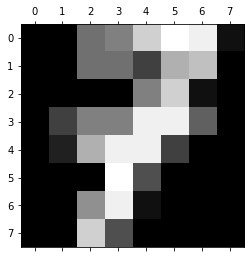

In [26]:
digit_to_predict=7
for i in range(len(dig.target)):
    if(dig.target[i]==digit_to_predict):
        break;
plt.matshow(dig.images[i])
print('Predicted value: ',model.predict(dig.data[i]))